In [1]:
#importando todas as bibliotecas necessárias
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn import hmm # Hidden Markov Model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# remover avisos desnecessários
import warnings
from urllib3.exceptions import InsecureRequestWarning
warnings.simplefilter('ignore', InsecureRequestWarning)

In [3]:
rj_df = {
    'atraso': 'https://monipe-central.rnp.br/esmond/perfsonar/archive/?source=monipe-rj-atraso.rnp.br&destination=monipe-df-atraso.rnp.br&time-range=10731552'
} # variável com URL representando os testes de Atraso; do RJ para DF, nos últimos 4 meses (10731552 segundos)

In [4]:
eventTypesList = ['time-error-estimates', 'packet-count-sent', 'packet-count-lost-bidir'] #eventos utilizados na análise e modelagem

In [5]:
eventTypeUrlsRjDf = {} #conjunto dos URLs gerados relacionados aos dados necessários

In [6]:
def fetch_single_data(url): #recuperar objetos relacionados à etapa 1
    try:
        response = requests.get(url, verify=False)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

In [7]:
for key, url in rj_df.items():
    jsonData = fetch_single_data(url)
    if jsonData:
        for item in jsonData:
            eventTypes = item.get("event-types", [])
            if eventTypes:
                for event_type_info in eventTypes:
                    eventType = event_type_info.get("event-type")
                    time_updated = event_type_info.get("time-updated")
                    if eventType and time_updated is not None and eventType in eventTypesList:
                        newUrl = f"{item['url']}/{eventType}/base?limit=100000"
                        if eventType not in eventTypeUrlsRjDf:
                            eventTypeUrlsRjDf[eventType] = set()
                        eventTypeUrlsRjDf[eventType].add(newUrl)

In [8]:
print(eventTypeUrlsRjDf)

{'packet-count-sent': {'https://monipe-central.rnp.br/esmond/perfsonar/archive/d2d9c566ffce4c8e9aa162e9096ef7fc//packet-count-sent/base?limit=100000', 'https://monipe-central.rnp.br/esmond/perfsonar/archive/cfd0750744604afdbb88606318e6c6f3//packet-count-sent/base?limit=100000', 'https://monipe-central.rnp.br/esmond/perfsonar/archive/441558232124448dbd2fd5d1834c74ef//packet-count-sent/base?limit=100000', 'https://monipe-central.rnp.br/esmond/perfsonar/archive/86506b4034824393aa88cce9b4350528//packet-count-sent/base?limit=100000', 'https://monipe-central.rnp.br/esmond/perfsonar/archive/9fd67dd09a8a4aa09d9fd473365581d9//packet-count-sent/base?limit=100000', 'https://monipe-central.rnp.br/esmond/perfsonar/archive/52d97b9684494da09a0e04c60458bea9//packet-count-sent/base?limit=100000', 'https://monipe-central.rnp.br/esmond/perfsonar/archive/d025d7c7bf5f4d029235ca1f237a11c7//packet-count-sent/base?limit=100000', 'https://monipe-central.rnp.br/esmond/perfsonar/archive/dd7845c7c8844904afdc86f59

In [9]:
def fetch_multiple_data(eventUrls): #recuperar e combinar o conjunto de dados retornados da URL relacionada ao evento
    combined_data = []
    for url in eventUrls:
        response = requests.get(url, verify=False)
        data = response.json()
        combined_data.extend(data)
    return combined_data

### Time Error Estimates: Unidirectional

In [10]:
combined_data = fetch_multiple_data(eventTypeUrlsRjDf['time-error-estimates'])
data = pd.DataFrame(combined_data)

In [11]:
# calculating basic statistics
mean_error = data['val'].mean()
max_error = data['val'].max()
min_error = data['val'].min()

print(f"Mean Time Error: {mean_error} ms")
print(f"Max Time Error: {max_error} ms")
print(f"Min Time Error: {min_error} ms")

Mean Time Error: 1.1086468673673302 ms
Max Time Error: 13.84 ms
Min Time Error: 0.08 ms


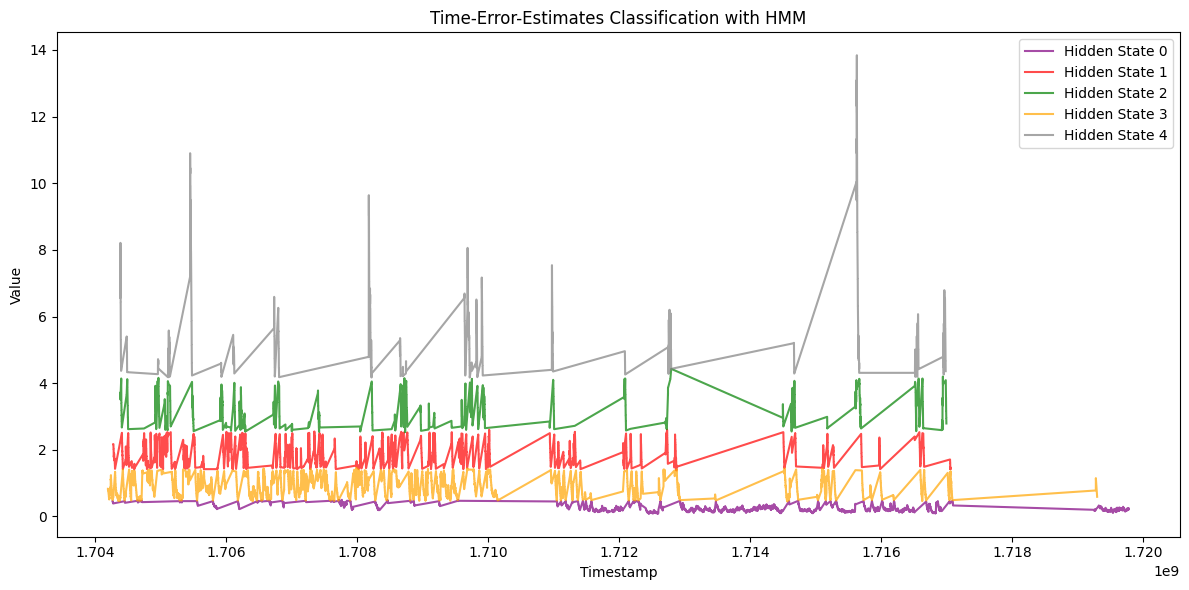

In [13]:
# sort and organize data
data.sort_values(by='ts', inplace=True)
observed_data = data['val'].values.reshape(-1, 1)

# number of hidden states
n_states = 5

# create HMM model
model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")

# fit the model to the observed data
model.fit(observed_data)

# predict the hidden states for the observed data
predicted_states = model.predict(observed_data)

# plot the time-error-estimates using HMM: classification graph
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['purple', 'red', 'green', 'orange', 'gray']
unique_states = np.unique(predicted_states)

# plot a line plot for each state
for state in unique_states:
    mask = (predicted_states == state)
    ax.plot(data['ts'][mask], data['val'][mask], color=colors[state],
            label=f'Hidden State {state}', alpha=0.7)

ax.set_title('Time-Error-Estimates Classification with HMM')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
ax.legend()
plt.tight_layout()
plt.show()

### Packet Count Lost: Bidirectional

In [14]:
combined_data = fetch_multiple_data(eventTypeUrlsRjDf['packet-count-lost-bidir'])
data = pd.DataFrame(combined_data)

In [15]:
X = data[['ts']] 
y = data['val']

In [16]:
# calculate basic statistics
mean_val = data['val'].mean()
median_val = data['val'].median()
std_val = data['val'].std()

print(f"Mean: {mean_val}, Median: {median_val}, Std Deviation: {std_val}")

Mean: 0.41955046177812394, Median: 0.0, Std Deviation: 1.9979473800588567


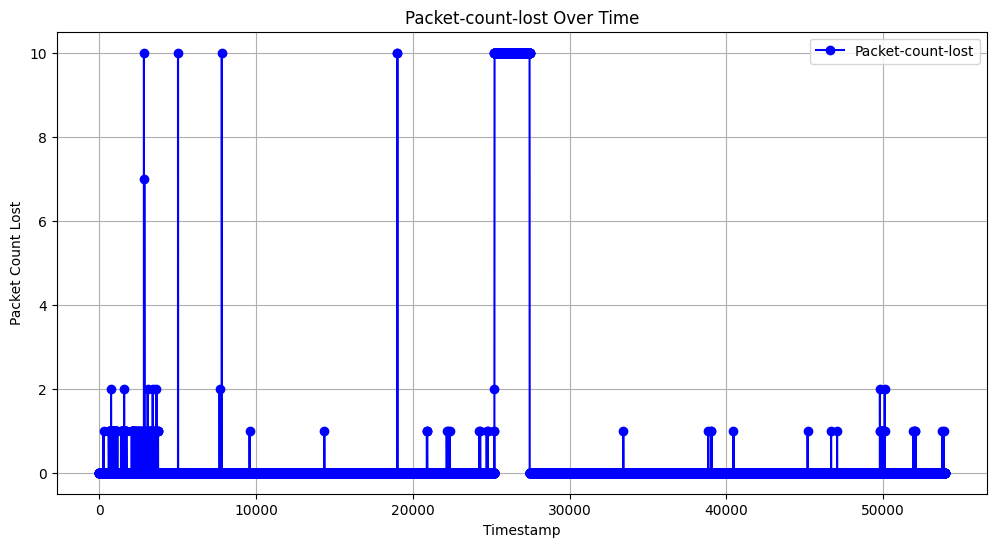

In [17]:
# plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['val'], marker='o', linestyle='-', color='b', label='Packet-count-lost')
plt.title('Packet-count-lost Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Packet Count Lost')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# 'ts' column in datetime format
data['ts'] = pd.to_datetime(data['ts'], unit='s')

# total time period in seconds
time_diff = (data['ts'].iloc[-1] - data['ts'].iloc[0]).total_seconds()

# total packets lost over the entire period
total_packets_lost = data['val'].sum()

arrival_rate = total_packets_lost / time_diff

print(f"Estimated Packet Lost Rate: {arrival_rate} packets/second")

Estimated Packet Lost Rate: 0.2680767863490935 packets/second


### Packet Count Sent: Bidirectional

In [35]:
combined_data = fetch_multiple_data(eventTypeUrlsRjDf['packet-count-sent'])
data = pd.DataFrame(combined_data)

In [36]:
# calculating basic statistics
mean_packet = data['val'].mean()
max_packet = data['val'].max()
min_packet = data['val'].min()

print(f"Mean Packet Sent: {mean_packet} ms")
print(f"Max Packet Sent: {max_packet} ms")
print(f"Min Packet Sent: {min_packet} ms")

Mean Packet Sent: 496.0195151880066 ms
Max Packet Sent: 1200.0 ms
Min Packet Sent: 9.0 ms


In [37]:
X = data[['ts']]
y = data['val']

# training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# predict on the test set
y_pred = model.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# additional evaluation metrics and reports
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.82
              precision    recall  f1-score   support

        10.0       0.00      0.00      0.00     13919
        39.0       0.00      0.00      0.00         1
        45.0       0.00      0.00      0.00         1
        51.0       0.00      0.00      0.00         1
        57.0       0.00      0.00      0.00         1
        64.0       0.00      0.00      0.00         2
        69.0       0.00      0.00      0.00         1
       161.0       0.00      0.00      0.00         1
       319.0       0.00      0.00      0.00         1
       331.0       0.00      0.00      0.00         6
       491.0       0.00      0.00      0.00         5
       503.0       0.00      0.00      0.00         1
       511.0       0.00      0.00      0.00         1
       591.0       0.00      0.00      0.00         1
       600.0       0.82      1.00      0.90     64780
      1200.0       0.00      0.00      0.00         2

    accuracy                           0.82     78724
   macro av

In [38]:
# predicting on new data
new_timestamp = 1688167226
new_data = pd.DataFrame({'ts': [new_timestamp]})
predicted_val = model.predict(new_data)

print(f"Predicted value for timestamp {new_timestamp}: {predicted_val[0]}")

Predicted value for timestamp 1688167226: 600.0
